# Práctica 4: Extracción de caracteristicas usando SIFT

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from skimage import color
%matplotlib inline

In [2]:
def segment_coins(img, filt):
    coins_mask = []
    full_mask = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if filt == 'gaussian':
        gray = cv2.GaussianBlur(gray, (15,15), 2, 2)
    elif filt == 'median':
        gray = cv2.medianBlur(gray, 9)
    # Binarizacion usando el metodo de Otsu 
    # determina automaticamente el umbral optimo
    _, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # Transformacion morfologica: closing
    # 20, 20
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((5,5), np.uint8), iterations = 2)
    # Transformacion morfologica: opening
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((20,20), np.uint8), iterations = 2)
    # Transformada de distancia
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    # Descartar el fondo de la imagen
    _, sure_fg = cv2.threshold(dist_transform,0.4*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    # Transformacion morfolofica: dilatacion
    dilation = cv2.dilate(sure_fg, np.ones((33,33), np.uint8), iterations=3)
    # Colocar etiquetas a cada moneda en la imagen
    # (agregar un numero entero a cada region)
    ret, markers = cv2.connectedComponents(dilation)
    full_mask.append(np.uint8(markers))
    # Creacion de las mascaras individuales, de cada moneda
    for mark in range(1, ret):
        coord_mask = np.where(markers==mark)
        coord_mask = [(x, y) for x, y in zip(coord_mask[0], coord_mask[1])]
        mask = np.zeros(gray.shape)
        for x, y in coord_mask:
            mask[x,y] = 1
        coins_mask.append(np.uint8(mask))
    return full_mask[0], coins_mask

In [3]:
def cmask(imgSet, f=None):
    '''
        Toma como entrada una imagen y regresa sus caracteristicas usando SIFT
    '''
    # Objeto sift para extraer caracteristicas
    sift = cv2.xfeatures2d.SIFT_create()
    cmasks = []             # Se almacenan 12 mascaras por cada imagen. dim=3x12
    fmasks = []             # Mascaras completas por imagen. dim=3x1
    keypoints = []          # Keypoints de cada mascara
    descriptors = []        # Descriptores de cada mascara. dim=3x12x2
    f_keypoints = []        # Keypoints de cada mascara completa dim=3
    for img in imgSet:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if f == None:
            full_mask, coins_mask = segment_coins(img, 'gaussian')
        elif f == 'median':
            full_mask, coins_mask = segment_coins(img, 'median')
        cmasks.append(coins_mask)
        fmasks.append(full_mask)
        # iterar en cada una de las 12 mascaras x imagen
        for mask in coins_mask:
            kp, desc = sift.detectAndCompute(gray, mask)
            descriptors.append([mask, desc])
            keypoints.append([mask, kp])
        kp, desc = sift.detectAndCompute(gray, full_mask)
        f_keypoints.append([full_mask, kp])
            
    return descriptors, keypoints, f_keypoints

In [4]:
# Lectura de las imagenes enfocadas sin ruido
imgs = []
imgs.append(cv2.imread('img/IMG_A_Foco.JPG', 1))
imgs.append(cv2.imread('img/IMG_B_Foco.JPG', 1))
imgs.append(cv2.imread('img/IMG_C_Foco.JPG', 1))

In [5]:
# Lectura de las imagenes enfocadas con ruido gaussiano
imgsNoiseG = []
imgsNoiseG.append(cv2.imread('img/IMG_A_Foco_gaussian.jpg', 1))
imgsNoiseG.append(cv2.imread('img/IMG_B_Foco_gaussian.jpg', 1))
imgsNoiseG.append(cv2.imread('img/IMG_C_Foco_gaussian.jpg', 1))

In [6]:
# Lectura de las imagenes enfocadas con ruido impulsivo
imgsNoiseI = []
imgsNoiseI.append(cv2.imread('img/IMG_A_Foco_saltPepper.jpg', 1))
imgsNoiseI.append(cv2.imread('img/IMG_B_Foco_saltPepper.jpg', 1))
imgsNoiseI.append(cv2.imread('img/IMG_C_Foco_saltPepper.jpg', 1))

In [7]:
# Conversion de canal BGR A RGB
for img, imgNoise, i in zip(imgs, imgsNoiseG, range(3)):
        imgs[i] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgsNoiseG[i] = cv2.cvtColor(imgNoise, cv2.COLOR_BGR2RGB)

### Extraccion de caracteristicas de las imagenes de entrenamiento

In [8]:
# Usar las imagenes A y B enfocadas como entrenamiento
imgsTraining = []
imgsTraining.append(imgs[:][0])
imgsTraining.append(imgs[:][1])

In [9]:
descriptorsTraining, keypointsTraining, f_keypointsTraining = cmask(imgsTraining)

In [10]:
# Obtener imagenes con los keypoints marcados
imgsKeypointTraining = []
# Primera imagen
for mask, kpt in keypointsTraining[0:12]:
    imgsTraining[0] = cv2.drawKeypoints(imgsTraining[0], kpt, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgsKeypointTraining.append(imgsTraining[0])
    
# Segunda imagen
for mask, kpt in keypointsTraining[12:24]:
    imgsTraining[1] = cv2.drawKeypoints(imgsTraining[1], kpt, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgsKeypointTraining.append(imgsTraining[1])

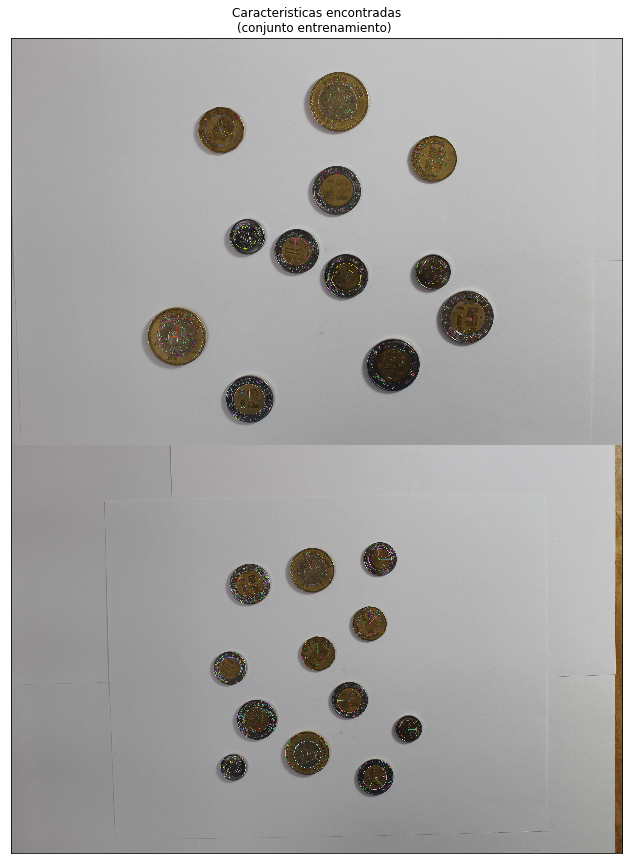

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(np.vstack((imgsKeypointTraining[0], imgsKeypointTraining[1])))
plt.title('Caracteristicas encontradas\n(conjunto entrenamiento) ')
plt.xticks([])
plt.yticks([])
plt.show()

### Extraccion de caracteristicas de imagenes de prueba

In [12]:
descriptorsTest, keypointsTest, f_keypointsTest = cmask(imgsNoiseG)

In [13]:
imgsTest = imgsNoiseG

for i in range(len(imgsTest)):
    imgsTest[i] = cv2.GaussianBlur(imgsTest[i], (15,15), 2, 2)

# Obtener imagenes con los keypoints marcados
imgsKeypointTest = []
# Primera imagen A
for mask, kpt in keypointsTest[0:12]:
    imgsTest[0] = cv2.drawKeypoints(imgsTest[0], kpt, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgsKeypointTest.append(imgsTest[0])
    
# Segunda imagen B
for mask, kpt in keypointsTest[12:24]:
    imgsTest[1] = cv2.drawKeypoints(imgsTest[1], kpt, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgsKeypointTest.append(imgsTest[1])

# Tercera imagen C
for mask, kpt in keypointsTest[24:36]:
    imgsTest[2] = cv2.drawKeypoints(imgsTest[2], kpt, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgsKeypointTest.append(imgsTest[2])

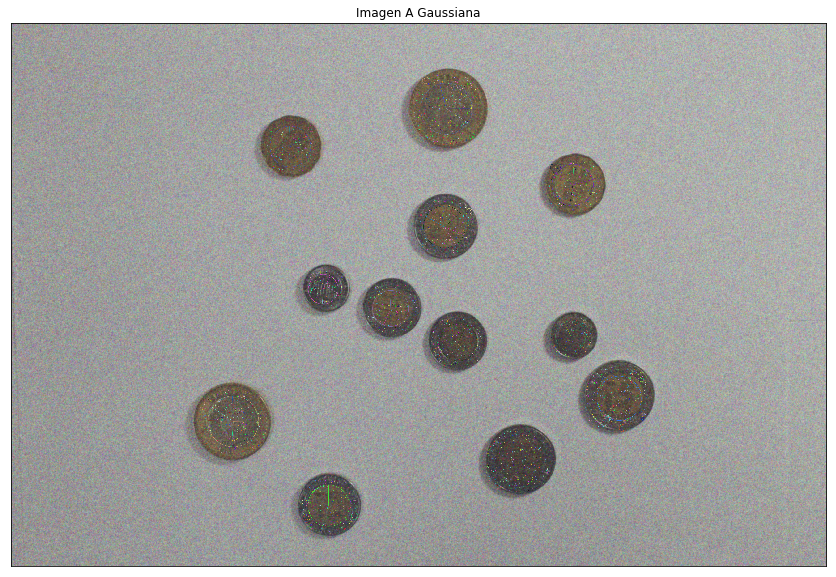

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(imgsKeypointTest[0])
plt.xticks([]), plt.yticks([])
plt.title('Imagen A Gaussiana')
plt.show()

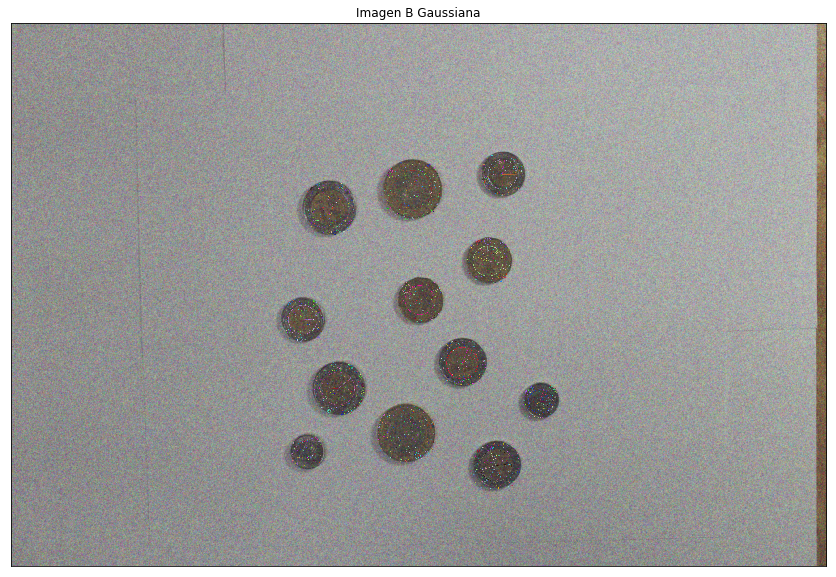

In [15]:
plt.figure(figsize=(15,10))
plt.imshow(imgsKeypointTest[1])
plt.xticks([]), plt.yticks([])
plt.title('Imagen B Gaussiana')
plt.show()

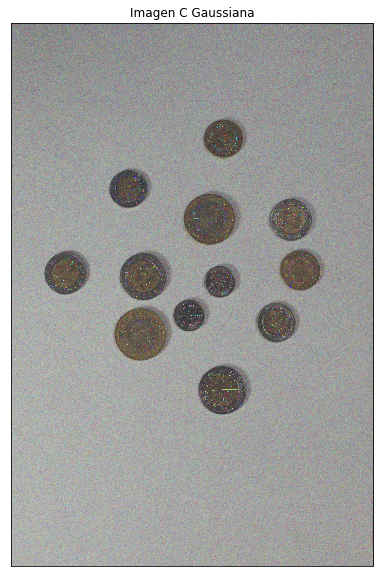

In [16]:
plt.figure(figsize=(15,10))
plt.imshow(imgsKeypointTest[2])
plt.xticks([]), plt.yticks([])
plt.title('Imagen C Gaussiana')
plt.show()

### Etiquetar las imagenes de entrenamiento

In [17]:
#descriptorsTraining[i][0] -> mascara
#descriptorsTraining[i][1] -> descriptores
# ...
#descriptorsTraining[23][1]

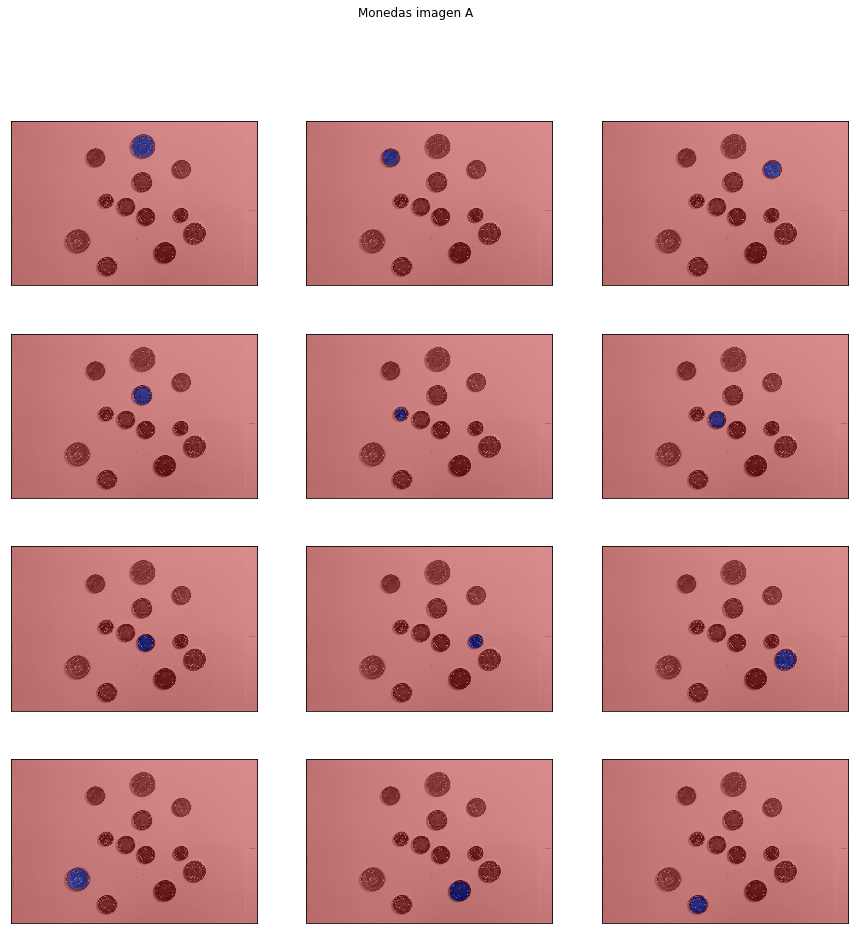

In [18]:
coinsA = plt.figure(figsize=(15,15))
coinsA.suptitle('Monedas imagen A')
for i in range(0, 12):
    plt.subplot(4,3,i+1)
    plt.imshow(color.label2rgb(descriptorsTraining[i][0], image=imgsTraining[0]))
    plt.xticks([])
    plt.yticks([])
plt.show()

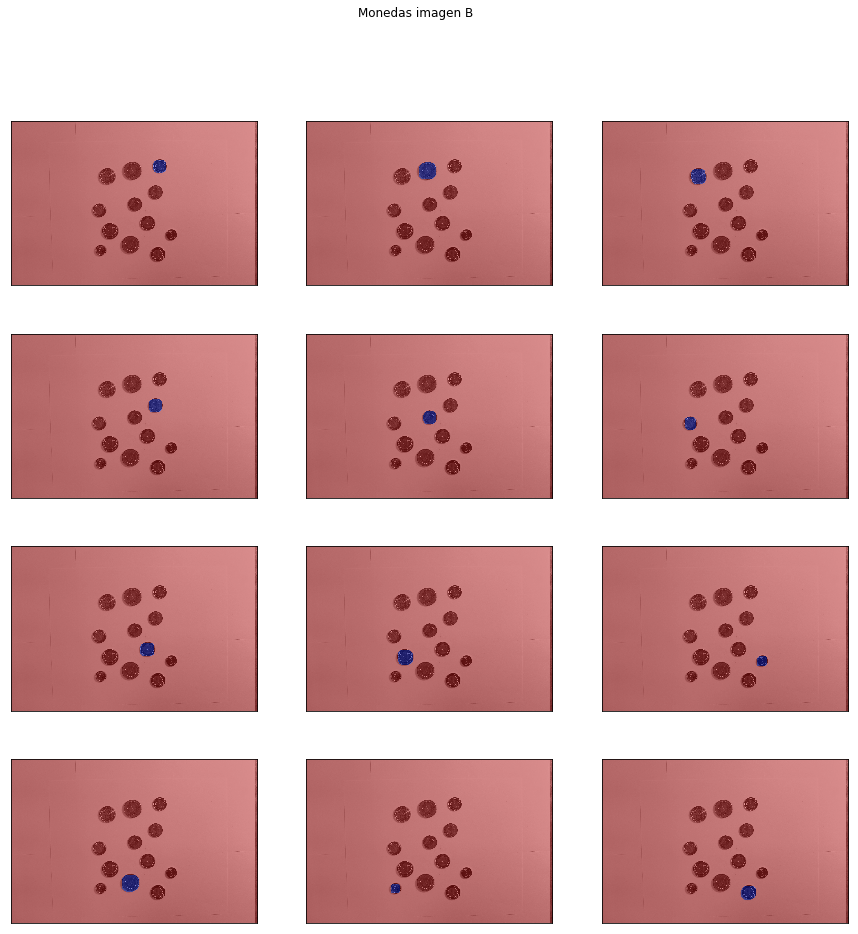

In [19]:
coinsB = plt.figure(figsize=(15,15))
coinsB.suptitle('Monedas imagen B')
for i in range(12, 24):
    plt.subplot(4,3,i-11)
    plt.imshow(color.label2rgb(descriptorsTraining[i][0], image=imgsTraining[1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

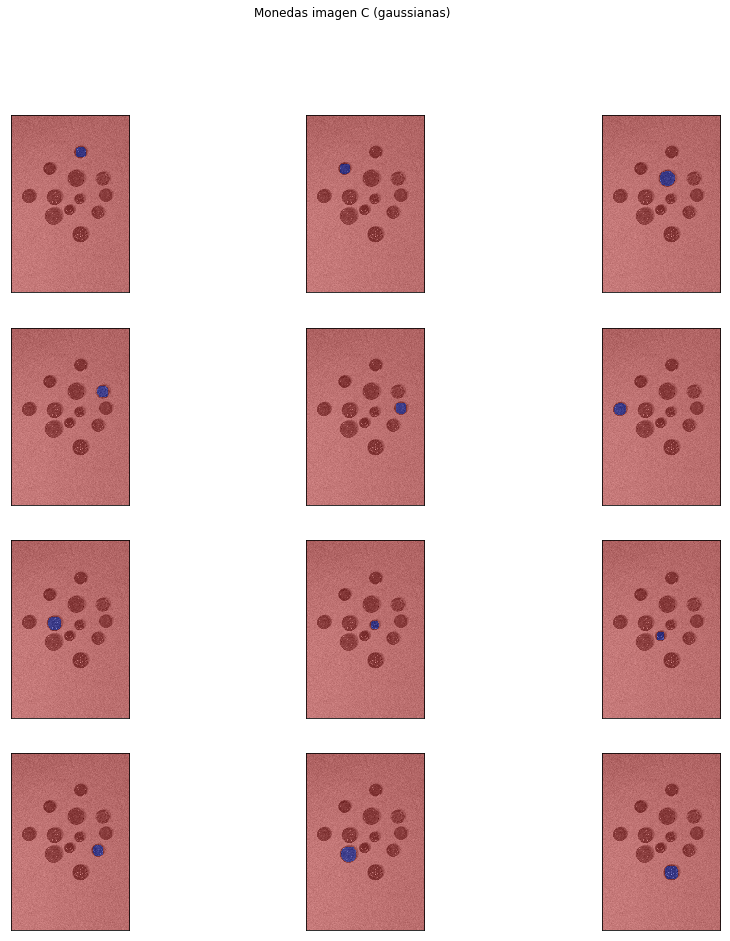

In [20]:
coinsCNG = plt.figure(figsize=(15,15))
coinsCNG.suptitle('Monedas imagen C (gaussianas)')
for i in range(24, 36):
    plt.subplot(4,3,i-23)
    plt.imshow(color.label2rgb(descriptorsTest[i][0], image=imgsTest[2]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [77]:
from sklearn import preprocessing
# Crear vector donde se almacenan los 24 descriptores de entrenamiento
# Cada vector tiene dim caracteristicas
dim = 300
X_training = []
for i in range(24):
    rows, cols = descriptorsTraining[i][1].shape
    X_training.append(descriptorsTraining[i][1].reshape(rows*cols)[:dim])
    
X_training = preprocessing.normalize(X_training, norm='l2')

In [112]:
print('Dimensiones de la matriz de descriptores')
print(descriptorsTraining[7][1].shape)

Dimensiones de la matriz de descriptores
(240, 128)


In [79]:
# Crear vector donde se almacenan los 24 descriptores de entrenamiento
# Cada vector tiene dim caracteristicas
X_test = []
for i in range(36):
    rows, cols = descriptorsTest[i][1].shape
    X_test.append(descriptorsTest[i][1].reshape(rows*cols)[:dim])
    
X_test = preprocessing.normalize(X_test, norm='l2')

In [80]:
# Crear vector objetivo con las clases a las que pertenecen las monedas
classes = {
    0:'0.50',
    1:'1',
    2:'2',
    3:'5',
    4:'10'
}

In [81]:
targets = np.zeros((24,), np.uint8())
# Monedas imagen A
targets[0] = 4
targets[1] = 0
targets[2] = 0
targets[3] = 2
targets[4] = 0
targets[5] = 1
targets[6] = 1
targets[7] = 0
targets[8] = 3
targets[9] = 4
targets[10] = 3
targets[11] = 2
# Monedas imagen B
targets[12] = 1
targets[13] = 4
targets[14] = 3
targets[15] = 0
targets[16] = 0
targets[17] = 1
targets[18] = 2
targets[19] = 3
targets[20] = 0
targets[21] = 4
targets[22] = 0
targets[23] = 2

targetC = np.zeros(12,)
# Monedas imagen C
targetC[0] = 0
targetC[1] = 1
targetC[2] = 4
targetC[3] = 2
targetC[4] = 0
targetC[5] = 2
targetC[6] = 3
targetC[7] = 0
targetC[8] = 0
targetC[9] = 1
targetC[10] = 4
targetC[11] = 3

### Clasificador Random Forest

In [106]:
'''
    parametros:
        dim = 3,000 y n_estimators = 20 --> 19.44%
        dim = 300 y n_estimators = 20 --> 20% - 30%
        
'''
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20, criterion='entropy')
rf.fit(X_training, targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [107]:
prediction = rf.predict(X_test)

In [108]:
real_labels = [classes[t] for t in targets]
real_c = [classes[t] for t in targetC]
real_labels = np.hstack((real_labels, real_c))
predicted_labels = [classes[p] for p in prediction] 

print('Monedas A')
print('Monedas reales\n', real_labels[:12])
print('Prediccion monedas\n', predicted_labels[:12])

print('\n\nMonedas B')
print('Monedas reales\n', real_labels[12:24])
print('Prediccion monedas\n', predicted_labels[12:24])

print('\n\nMonedas C')
print('Monedas reales\n', real_labels[24:36])
print('Prediccion monedas\n', predicted_labels[24:36])

Monedas A
Monedas reales
 ['10' '0.50' '0.50' '2' '0.50' '1' '1' '0.50' '5' '10' '5' '2']
Prediccion monedas
 ['0.50', '0.50', '0.50', '0.50', '10', '10', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50']


Monedas B
Monedas reales
 ['1' '10' '5' '0.50' '0.50' '1' '2' '5' '0.50' '10' '0.50' '2']
Prediccion monedas
 ['0.50', '0.50', '0.50', '0.50', '0.50', '5', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50']


Monedas C
Monedas reales
 ['0.50' '1' '10' '2' '0.50' '2' '5' '0.50' '0.50' '1' '10' '5']
Prediccion monedas
 ['0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '5', '0.50', '5', '0.50', '0.50']


In [109]:
precision = np.sum([1 if c1==c2 else 0 for c1, c2 in zip(real_labels, predicted_labels)])/36*100
print('precision = ', precision)

precision =  27.77777777777778


### Referencias

https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html

https://www.youtube.com/watch?v=Fe-KWKPk9Zc (feature matching)

https://www.youtube.com/watch?v=USl5BHFq2H4 (feature detection)